# Checkpoint 1

Reminder: 

- You are being evaluated for compeletion and effort in this checkpoint. 
- Avoid manual labor / hard coding as much as possible, everything we've taught you so far are meant to simplify and automate your process.

We will be working with the same `states_edu.csv` that you should already be familiar with from the tutorial.

We investigated Grade 8 reading score in the tutorial. For this checkpoint, you are asked to investigate another test. Here's an overview:

* Choose a specific response variable to focus on
>Grade 4 Math, Grade 4 Reading, Grade 8 Math
* Pick or create features to use
>Will all the features be useful in predicting test score? Are some more important than others? Should you standardize, bin, or scale the data?
* Explore the data as it relates to that test
>Create at least 2 visualizations (graphs), each with a caption describing the graph and what it tells us about the data
* Create training and testing data
>Do you want to train on all the data? Only data from the last 10 years? Only Michigan data?
* Train a ML model to predict outcome 
>Define what you want to predict, and pick a model in sklearn to use (see sklearn <a href="https://scikit-learn.org/stable/modules/linear_model.html">regressors</a>.
* Summarize your findings
>Write a 1 paragraph summary of what you did and make a recommendation about if and how student performance can be predicted

Include comments throughout your code! Every cleanup and preprocessing task should be documented.

Of course, if you're finding this assignment interesting (and we really hope you do!), you are welcome to do more than the requirements! For example, you may want to see if expenditure affects 4th graders more than 8th graders. Maybe you want to look into the extended version of this dataset and see how factors like sex and race are involved. You can include all your work in this notebook when you turn it in -- just always make sure you explain what you did and interpret your results. Good luck!

<h2> Data Cleanup </h2>

Import `numpy`, `pandas`, and `matplotlib`.

(Feel free to import other libraries!)

I will focus on Grade 8 Math :)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# Suppress Pandas SettingWithCopyWarning
pd.options.mode.chained_assignment = None

Load in the "states_edu.csv" dataset and take a look at the head of the data

In [20]:
df = pd.read_csv('../data/states_edu.csv')
df.head()
df.columns

Index(['PRIMARY_KEY', 'STATE', 'YEAR', 'ENROLL', 'TOTAL_REVENUE',
       'FEDERAL_REVENUE', 'STATE_REVENUE', 'LOCAL_REVENUE',
       'TOTAL_EXPENDITURE', 'INSTRUCTION_EXPENDITURE',
       'SUPPORT_SERVICES_EXPENDITURE', 'OTHER_EXPENDITURE',
       'CAPITAL_OUTLAY_EXPENDITURE', 'GRADES_PK_G', 'GRADES_KG_G',
       'GRADES_4_G', 'GRADES_8_G', 'GRADES_12_G', 'GRADES_1_8_G',
       'GRADES_9_12_G', 'GRADES_ALL_G', 'AVG_MATH_4_SCORE', 'AVG_MATH_8_SCORE',
       'AVG_READING_4_SCORE', 'AVG_READING_8_SCORE'],
      dtype='object')

You should always familiarize yourself with what each column in the dataframe represents. Read about the states_edu dataset here: https://www.kaggle.com/noriuk/us-education-datasets-unification-project

Use this space to rename columns, deal with missing data, etc. _(optional)_

In [24]:
# let's rename our columns to make them more intuitive
df.rename({
    'GRADES_PK_G':'ENROLL_PREK',
    'GRADES_KG_G':'ENROLL_KINDER',
    'GRADES_4_G':'ENROLL_4',
    'GRADES_8_G':'ENROLL_8',
    'GRADES_12_G':'ENROLL_12',
    'GRADES_1_8_G':'ENROLL_PRIMARY',
    'GRADES_9_12_G':'ENROLL_HS',
    'GRADES_ALL_G':'ENROLL_ALL',
    'ENROLL':'ENROLL_ALL_EST'
    },
    axis=1,inplace=True)
#inplace return copy of dataframe
# by default, dropna will remove all rows with at least 1 nan
df.dropna(subset=['AVG_MATH_8_SCORE'], inplace=True)

<h2>Exploratory Data Analysis (EDA) </h2>

Chosen Outcome Variable for Test: *OUT*

How many years of data are logged in our dataset? 

In [11]:
len(df['YEAR'].unique())

13

Let's compare Michigan to Ohio. Which state has the higher average outcome score across all years?

In [15]:
filtered_df = df[df['STATE'].isin(['MICHIGAN', 'OHIO'])] # Filter the dataframe for only Michigan and Ohio
average_scores = filtered_df.groupby('STATE')['AVG_MATH_8_SCORE'].mean() # Group by state and calculate the average outcome score
# print(average_scores)
higher_average_state = average_scores.idxmax()
print(f"\n{higher_average_state} has the higher average outcome score across all years.")


OHIO has the higher average outcome score across all years.


Find the average for your outcome score across all states in 2019

In [16]:
df_2019 = df[df['YEAR'] == 2019]  # Filter the dataframe for only YEAR 2019
average_score_2019 = df_2019['AVG_MATH_8_SCORE'].mean()
print(f"The average outcome score across all states in 2019 is {average_score_2019:.2f}.")

The average outcome score across all states in 2019 is 281.26.


Find the maximum outcome score for every state. 

Refer to the `Grouping and Aggregating` section in Tutorial 0 if you are stuck.

In [19]:
max_scores = df.groupby('STATE')['AVG_MATH_8_SCORE'].max() # Group by state and calculate the maximum outcome score for each state
print(max_scores)

STATE
ALABAMA                 269.0
ALASKA                  283.0
ARIZONA                 283.0
ARKANSAS                279.0
CALIFORNIA              277.0
COLORADO                292.0
CONNECTICUT             289.0
DELAWARE                284.0
DISTRICT_OF_COLUMBIA    269.0
DODEA                   293.0
FLORIDA                 281.0
GEORGIA                 281.0
HAWAII                  281.0
IDAHO                   287.0
ILLINOIS                285.0
INDIANA                 288.0
IOWA                    286.0
KANSAS                  290.0
KENTUCKY                282.0
LOUISIANA               273.0
MAINE                   289.0
MARYLAND                288.0
MASSACHUSETTS           301.0
MICHIGAN                280.0
MINNESOTA               295.0
MISSISSIPPI             274.0
MISSOURI                286.0
MONTANA                 293.0
NATIONAL                285.0
NEBRASKA                288.0
NEVADA                  278.0
NEW_HAMPSHIRE           296.0
NEW_JERSEY              296.0
NEW_

<h2> Feature Engineering </h2>

After exploring the data, you can choose to modify features that you would use to predict the performance of the students on your chosen response variable. 

You can also create your own features. For example, perhaps you figured that maybe a state's expenditure per student may affect their overall academic performance so you create a expenditure_per_student feature.

Use this space to modify or create features.

In [25]:
df['ENROLL_ALL'] = df['ENROLL_ALL'].fillna(df["ENROLL_PREK"]+df["ENROLL_PRIMARY"]+df["ENROLL_HS"])

# let's create a new column which represents expenditure per student
df['SUPPORT_SERVICES_EXPENDITURE_PER_STUDENT'] = df['SUPPORT_SERVICES_EXPENDITURE'] / df['ENROLL_ALL']

Feature engineering justification: **<BRIEFLY DESCRIBE WHY YOU MADE THE CHANGES THAT YOU DID\>**

<h2>Visualization</h2>

Investigate the relationship between your chosen response variable and at least two predictors using visualizations. Write down your observations.

**Visualization 1**

<Axes: title={'center': 'Distribution of 8th Grade Math Scores'}, ylabel='Frequency'>

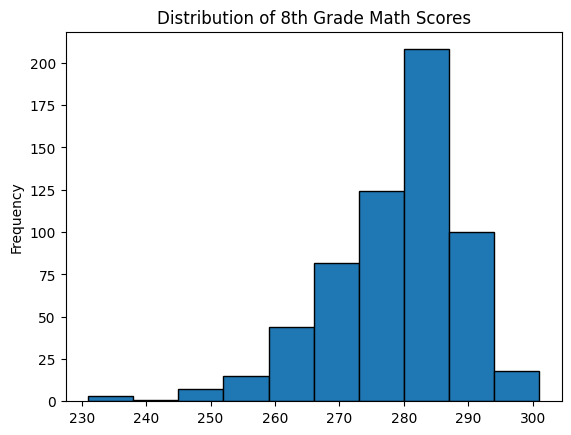

In [26]:
df.AVG_MATH_8_SCORE.plot.hist(title="Distribution of 8th Grade Math Scores", edgecolor="black")

**Distribution of 8th Grade Math Scores**

**Visualization 2**

Text(0.5, 1.0, '8th Grade Math Score Over Time')

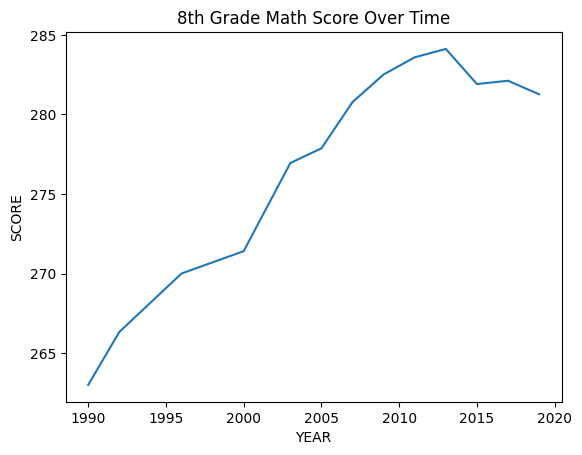

In [27]:
df.groupby('YEAR')["AVG_MATH_8_SCORE"].mean().plot()
plt.ylabel('SCORE')
plt.title('8th Grade Math Score Over Time')

**8th Grade Math Score Over Time**

<h2> Data Creation </h2>

_Use this space to create train/test data_

In [28]:
from sklearn.model_selection import train_test_split

In [38]:
# X is commonly used to denote the input data
# y is used for the response / output data
X = df[['ENROLL_8','AVG_MATH_8_SCORE','AVG_READING_4_SCORE']].dropna()
y = df.loc[X.index]['AVG_READING_8_SCORE']

In [39]:
# X_train, X_test, y_train, y_test = train_test_split(
#      X, y, test_size=, random_state=42)
# We also need to make sure there is no NaN in y
# This time, we will fill the NaN with the median of y 
# We prefer median to mean because EDA reveals that the response variable is left-skewed. Therefore, the mean may not represent the data very well
y.fillna(y.median(), inplace=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=0)

<h2> Prediction </h2>

ML Models [Resource](https://medium.com/@vijaya.beeravalli/comparison-of-machine-learning-classification-models-for-credit-card-default-data-c3cf805c9a5a)

In [31]:
# import your sklearn class here
from sklearn.linear_model import LinearRegression

In [40]:
# create your model here
# model = 
model = LinearRegression()

In [41]:
model.fit(X_train, y_train)

LinearRegression()

In [42]:
y_pred = model.predict(X_test)

## Evaluation

Choose some metrics to evaluate the performance of your model, some of them are mentioned in the tutorial.

In [43]:
# You can see the intercepts and coefficients the model generates
print(model.intercept_)
print(model.coef_)
# R^2 value describes how well a linear model fits the data
# It ranges between 0 and 1
# There are many caveats to R^2 but it is a good starting point
model.score(X_test, y_test)
# mean error
np.mean(model.predict(X_test)-y_test)
# mean absolute error
np.mean(np.abs(model.predict(X_test)-y_test))
# root mean squared error -- penalizes large errors
np.mean((model.predict(X_test)-y_test)**2)**0.5

85.76241009688681
[-2.06735839e-06  1.42473788e-01  6.29509001e-01]


4.741191671782514

We have copied over the graphs that visualize the model's performance on the training and testing set. 

Change `col_name` and modify the call to `plt.ylabel()` to isolate how a single predictor affects the model.

Text(0.5, 1.0, 'Model Behavior On Training Set')

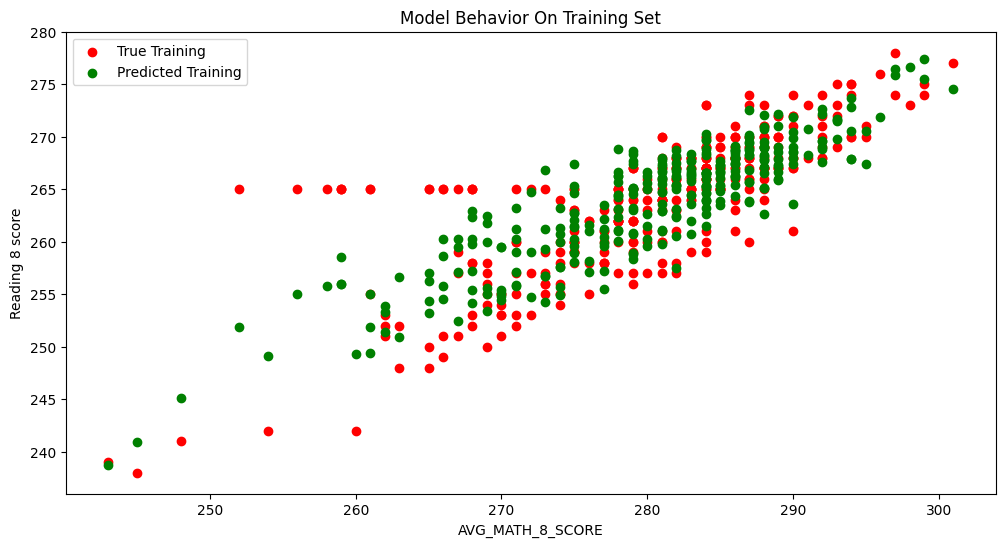

In [44]:
col_name = 'AVG_MATH_8_SCORE'

f = plt.figure(figsize=(12,6))
plt.scatter(X_train[col_name], y_train, color = "red")
plt.scatter(X_train[col_name], model.predict(X_train), color = "green")
plt.legend(['True Training','Predicted Training'])
plt.xlabel(col_name)
plt.ylabel('Reading 8 score')
plt.title("Model Behavior On Training Set")

Text(0.5, 1.0, 'Model Behavior on Testing Set')

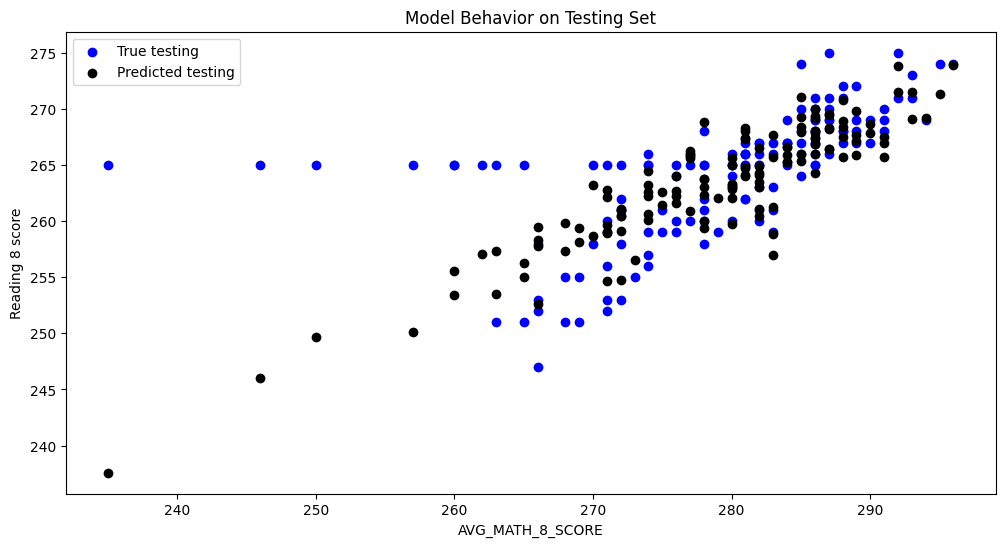

In [45]:
col_name = 'AVG_MATH_8_SCORE'

f = plt.figure(figsize=(12,6))
plt.scatter(X_test[col_name], y_test, color = "blue")
plt.scatter(X_test[col_name], model.predict(X_test), color = "black")

plt.legend(['True testing','Predicted testing'])
plt.xlabel(col_name)
plt.ylabel('Reading 8 score')
plt.title("Model Behavior on Testing Set")

<h2> Summary </h2>

**I tried to guess 8th-grade math scores using the number of students, 4th-grade math scores, and 8th-grade reading scores. Some data was missing, so I deleted those rows. Mp, my model gave me some ideas about what affects math scores, but there's room to make it better.**

**The thing is that I later realized I can simply copy and paste what I learned in the tutorial lol.**